In [1]:
import sys
sys.path.append("..")

import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import examples.util as util
import dforest
import query

In [2]:
# Numpy options
np.random.seed(12345)
np.set_printoptions(precision=1, suppress=True)

In [3]:
# Load dataset
data_X, data_y = fetch_california_housing(return_X_y=True)

# Shuffle and split data
train_X, train_y, test_X, test_y = util.split(data_X, data_y)

In [4]:
# Train models
rf_model = RandomForestRegressor(max_features=0.5)
rf2_model = RandomForestRegressor(max_features=0.5, max_depth=15)
bag_model = RandomForestRegressor()
bag2_model = RandomForestRegressor(max_depth=15)

rf_model.fit(train_X, train_y)
rf2_model.fit(train_X, train_y)
bag_model.fit(train_X, train_y)
bag2_model.fit(train_X, train_y)

RandomForestRegressor(max_depth=15)

In [5]:
# Eval models
_ = util.eval_model(rf_model, train_X, train_y, test_X, test_y, "Random Forest")
_ = util.eval_model(rf2_model, train_X, train_y, test_X, test_y, "Random Forest (Max Depth = 15)")
_ = util.eval_model(bag_model, train_X, train_y, test_X, test_y, "Bagging")
_ = util.eval_model(bag2_model, train_X, train_y, test_X, test_y, "Bagging (Max Depth = 15)")

Random Forest - Train Loss: 0.03377348345832746
Random Forest - Test Loss: 0.23260430927718628
Random Forest (Max Depth = 15) - Train Loss: 0.0625497560231418
Random Forest (Max Depth = 15) - Test Loss: 0.23891828721169797
Bagging - Train Loss: 0.035867153748654054
Bagging - Test Loss: 0.2460216879893064
Bagging (Max Depth = 15) - Train Loss: 0.058973843252619014
Bagging (Max Depth = 15) - Test Loss: 0.24996332893442752


In [6]:
# Random Forest robustness queries
rf = dforest.make_forest_sklearn(rf_model)
rf2 = dforest.make_forest_sklearn(rf2_model)
rf.print_summary()
rf2.print_summary()

Size of forest: 100
Average Tree Size: 10085.27
Avg Max Depth: 34.1
Minimum: [0.1579916, None]
Maximum: [None, 5.000010000000001]
Size of forest: 100
Average Tree Size: 3994.73
Avg Max Depth: 15.0
Minimum: [0.1584916, None]
Maximum: [None, 5.000010000000001]


In [15]:
delta = np.std(train_X, 0) / 20
eps = 0.8
x, y = test_X[1234], test_y[1234]
print(f"x: {x}, y: {y}, f(x): {rf.eval(x)}")
prune = rf.copy().prune_box(x - delta, x + delta)
prune.merge(5)
prune.print_summary()
prune.free()

x: [   3.3   52.     8.4    1.5  582.     1.9   36.5 -121.9], y: 5.00001, f(x): 3.350430299999999
Size of forest: 5
Average Tree Size: 14362.6
Avg Max Depth: 21.2
Minimum: [2.0781001, 3.350430299999999]
Maximum: [3.350430299999999, 4.1416017]


In [8]:
# Bagging robustness queries
bag = dforest.make_forest_sklearn(bag_model)
bag2 = dforest.make_forest_sklearn(bag2_model)
bag.print_summary()
bag2.print_summary()

Size of forest: 100
Average Tree Size: 10041.95
Avg Max Depth: 33.23
Minimum: [0.1579916, None]
Maximum: [None, 5.000010000000002]
Size of forest: 100
Average Tree Size: 4113.03
Avg Max Depth: 15.0
Minimum: [0.15924190000000002, None]
Maximum: [None, 5.000010000000001]


In [ ]:
n_trials = 100
kwargs = {"pso_max_iters": 5, "merge_limit": 15, "offset_factor": 0.1}
delta = np.std(train_X, 0) / 20
eps = 0.8
rf_res = query.robustness_query_many(rf, test_X[0:n_trials], delta, eps, **kwargs)

In [13]:
rf2_res = query.robustness_query_many(rf2, test_X[0:n_trials], delta, eps, **kwargs)

In [14]:
bag_res = query.robustness_query_many(bag, test_X[0:n_trials], delta, eps, **kwargs)

In [15]:
bag2_res = query.robustness_query_many(bag2, test_X[0:n_trials], delta, eps, **kwargs)

In [16]:
res = [rf_res, rf2_res, bag_res, bag2_res]
true = [len(x[0]) for x in res]
false = [len(x[1]) for x in res]
none = [len(x[2]) for x in res]

Text(0.5, 1.0, 'Queries Proven by Model')

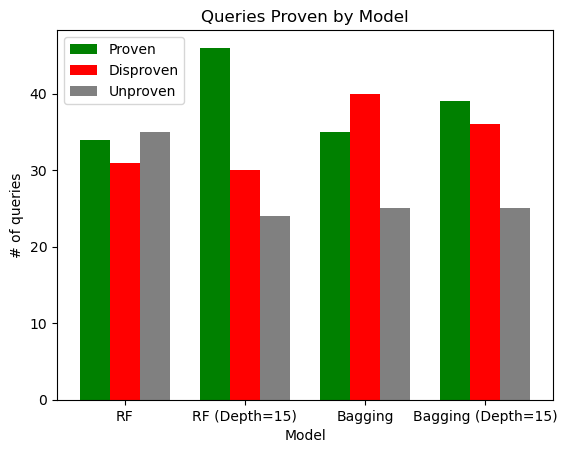

In [ ]:
import matplotlib.pyplot as plt

models = ["RF", "RF (Depth=15)", "Bagging", "Bagging (Depth=15)"]
bar_width = 0.25
true_x = np.arange(len(true))
false_x = true_x + bar_width
none_x = false_x + bar_width

plt.bar(true_x, true, width=bar_width, color="g", label="Proven")
plt.bar(false_x, false, width=bar_width, color="r", label="Disproven")
plt.bar(none_x, none, width=bar_width, color="grey", label="Unproven")
plt.legend()
plt.xticks(false_x, models)
plt.xlabel("Model")
plt.ylabel("# of queries")
plt.title("Queries Proven by Model")